In [1]:
# import dependencies
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
# load beyondemlx library locally
import sys
sys.path.append('../beyondemlx')

from beyondemlx.config.YamlRunConfig import YamlRunConfig
from beyondemlx.emlx.EmlxMail import EmlxMail

In [3]:
# load configuration
config = YamlRunConfig('../config/run.yaml')
config.load()

In [4]:
# load mails
mail_directory = config.get('MAIL_DIRECTORY')

paths = list(Path(mail_directory).rglob("*.[eE][mM][lL][xX]"))
emlx_mails = [EmlxMail.from_file(str(path)) for path in paths]

In [5]:
def analyse_numbers(mail_data):
    domains = set()
    users = {}
    mails = set()
    tos = set()
    froms = set()
    ccs = set()
    bccs = set()
    for mail in mail_data:
        # skip mails without necessary headers (i.e. calendar files)
        if not mail.has_necessary_headers():
            continue
    
        # add mail
        mails.add(mail)
    
        for participant in mail.get_to():
            tos.add(participant.get_email())
            
        for participant in mail.get_from():
            froms.add(participant.get_email())
            
        for participant in mail.get_cc():
            ccs.add(participant.get_email())
            
        for participant in mail.get_bcc():
            bccs.add(participant.get_email())
            
        # add participants
        participants = mail.get_from() + mail.get_to() + mail.get_cc() + mail.get_bcc()
        for participant in participants:
            # add domain
            domains.add(participant.get_domain())
    
            # add user
            if participant.get_email() not in users:
                users[participant.get_email()] = participant
                
    print("====== Numbers ======")
    print(f"Domains: {len(domains)}")
    print(f"Users: {len(users)}")
    print(f"Mails: {len(mails)}")
    print(f"To: {len(tos)}")
    print(f"From: {len(froms)}")
    print(f"CC: {len(ccs)}")
    print(f"BCC: {len(bccs)}")


In [6]:
def analyse_timestamps(email_data, start_year = None, end_year = None, scale = 'linear'):
    timestamps = [mail.get_date() for mail in email_data if mail.get_date() is not None]
    timestamps = sorted(timestamps)
    
    # filter by start and end year
    if start_year is not None:
        timestamps = [timestamp for timestamp in timestamps if timestamp.year >= start_year]
    if end_year is not None:
        timestamps = [timestamp for timestamp in timestamps if timestamp.year <= end_year]
    
    print("====== Timestamps ======")
    print(f"First: {timestamps[0]}")
    print(f"Last: {timestamps[-1]}")
    
    # plot as a histogram based on years
    years = [timestamp.year for timestamp in timestamps]
    
    # group by year
    per_year = {}
    for year in years:
        if year not in per_year:
            per_year[year] = 0
        per_year[year] += 1
        
    print(per_year)
    
    fig, ax = plt.subplots()
    ax.bar(per_year.keys(), per_year.values())
    
    # set log scale if necessary
    if scale == 'log':
        ax.set_yscale('log')
    
    ax.set_ylabel('Number of mails')
    ax.set_xlabel('Year')
    ax.set_title('Number of mails per year')
    
    # set x label to years 90 degree rotated
    ax.set_xticks([i for i in range(min(years), max(years)+1)])
    ax.set_xticklabels([str(i) for i in range(min(years), max(years)+1)], rotation=45)
    
    # hide every second label
    for label in ax.get_xticklabels()[1::2]:
        label.set_visible(False)
    
    ax.set_yticklabels([str(i)[:-2] for i in ax.get_yticks()])
    
    fig.tight_layout()
    plt.show()

In [7]:
def analyse_connection_numbers(email_data, max_number = 10):
    number_tos = [0 for _ in range(max_number)]
    number_ccs = [0 for _ in range(max_number)]
    number_bccs = [0 for _ in range(max_number)]
    
    # count how many tos, froms, ccs, bccs each mail has and add to dict
    for mail in email_data:
        # skip mails without necessary headers (i.e. calendar files)
        if not mail.has_necessary_headers():
            continue
    
        # add participants
        if len(mail.get_to()) < max_number:
            number_tos[len(mail.get_to())] += 1
        if len(mail.get_cc()) < max_number:
            number_ccs[len(mail.get_cc())] += 1
        if len(mail.get_bcc()) < max_number:
            number_bccs[len(mail.get_bcc())] += 1
        
    # find highest index with non-zero over all lists
    max_index = 0
    for i in range(max_number):
        if number_tos[i] > 0 or number_ccs[i] > 0 or number_bccs[i] > 0:
            max_index = i
            
    number_tos = number_tos[:max_index]
    number_ccs = number_ccs[:max_index]
    number_bccs = number_bccs[:max_index]
        
    # plot as a single bar chart with 4 bars per number
    print("====== Connection Numbers ======")
    fig, ax = plt.subplots()
    width = 0.25
    x = [i for i in range(max_index)]
    rects1 = ax.bar(x, number_tos, width, label='To')
    rects2 = ax.bar([i + width * 1 for i in x], number_ccs, width, label='CC')
    rects3 = ax.bar([i + width * 2 for i in x], number_bccs, width, label='BCC')
    
    ax.set_ylabel('Number of mails')
    ax.set_xlabel('Number of participants')
    ax.set_title('Number of mails per number of participants')
    ax.set_xticks([i + width * 1.5 for i in x])
    ax.set_xticklabels([str(i) for i in x])
    ax.set_yscale('log')
    ax.set_yticklabels([str(i) for i in ax.get_yticks()])
    ax.legend()
    
    fig.tight_layout()
    plt.show()

In [8]:
def analyse_shares(email_data):
    tos = {}
    froms = {}
    
    for mail in email_data:
        # skip mails without necessary headers (i.e. calendar files)
        if not mail.has_necessary_headers():
            continue
    
        # add participants
        for participant in mail.get_to():
            # add to
            if participant.get_email() not in tos:
                tos[participant.get_email()] = 0
            tos[participant.get_email()] += 1
            
        for participant in mail.get_from():
            # add to
            if participant.get_email() not in froms:
                froms[participant.get_email()] = 0
            froms[participant.get_email()] += 1
            
    # get top 10
    top_tos = sorted(tos.items(), key=lambda x: x[1], reverse=True)[:10]
    top_froms = sorted(froms.items(), key=lambda x: x[1], reverse=True)[:10]
    
    labels_tos = [x[0] for x in top_tos]
    sizes_tos = [x[1] for x in top_tos]
    
    labels_froms = [x[0] for x in top_froms]
    sizes_froms = [x[1] for x in top_froms]
    
    print("====== Shares (To) ======")
    fig, ax = plt.subplots()
    ax.pie(sizes_tos, labels=labels_tos, autopct='%1.1f%%')
    
    plt.show()
    plt.clf()
    
    print("====== Shares (From) ======")
    fig, ax = plt.subplots()
    ax.pie(sizes_froms, labels=labels_froms, autopct='%1.1f%%')
    
    plt.show()
    plt.clf()

In [9]:
def analyse_heatmap(emlx_mails, n):
    # find froms and tos
    froms = {}
    tos = {}
    
    for mail in emlx_mails:
        # skip mails without necessary headers (i.e. calendar files)
        if not mail.has_necessary_headers():
            continue
    
        # add participants
        receivers = mail.get_to() + mail.get_cc() + mail.get_bcc()
        for participant in receivers:
            # add to
            if participant.get_email() not in tos:
                tos[participant.get_email()] = 0
            tos[participant.get_email()] += 1
            
        for participant in mail.get_from():
            # add to
            if participant.get_email() not in froms:
                froms[participant.get_email()] = 0
            froms[participant.get_email()] += 1
            
    # get top n
    top_tos = sorted(tos.items(), key=lambda x: x[1], reverse=True)[:n]
    top_froms = sorted(froms.items(), key=lambda x: x[1], reverse=True)[:n]
    
    # create matrix
    matrix = [[0 for _ in range(n)] for _ in range(n)]
    
    # iterate over mails and fill matrix
    for mail in emlx_mails:
        # skip mails without necessary headers (i.e. calendar files)
        if not mail.has_necessary_headers():
            continue
    
        # get from and to
        senders = mail.get_from()
        receivers = mail.get_to() + mail.get_cc() + mail.get_bcc()
        for from_ in senders:
            for to in receivers:
                # get indices
                from_index = -1
                to_index = -1
                for i in range(n):
                    if top_froms[i][0] == from_.get_email():
                        from_index = i
                    if top_tos[i][0] == to.get_email():
                        to_index = i
                        
                # skip if not in top n
                if from_index == -1 or to_index == -1:
                    continue
                
                # add to matrix
                matrix[from_index][to_index] += 1
        
    # plot seaborn heatmap
    print("====== Heatmap ======")
    s = sns.heatmap(
        matrix, 
        annot=True,
        fmt=".0f",
        xticklabels=[x[0] for x in top_tos], 
        yticklabels=[x[0] for x in top_froms],
        norm=LogNorm(),
    )
    s.set(xlabel='Received (To, CC, BCC)', ylabel='Sent (From)')
    

====== Numbers ======
Domains: 2800
Users: 18343
Mails: 150971
To: 14909
From: 5924
CC: 5324
BCC: 542
====== Timestamps ======
First: 1980-01-03 23:27:50+01:00
Last: 2023-11-16 13:04:20+00:00
{1980: 1, 1988: 1, 2000: 140, 2001: 298, 2002: 481, 2003: 901, 2004: 1972, 2005: 3409, 2006: 4044, 2007: 3004, 2008: 3428, 2009: 4832, 2010: 6714, 2011: 10166, 2012: 6560, 2013: 5569, 2014: 5624, 2015: 5514, 2016: 7352, 2017: 6936, 2018: 8096, 2019: 8710, 2020: 17012, 2021: 13121, 2022: 13190, 2023: 9736}


/var/folders/xv/v1t23m813h93mw4xw90v_x_00000gn/T/ipykernel_32724/2890229088.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(i) for i in ax.get_yticks()])


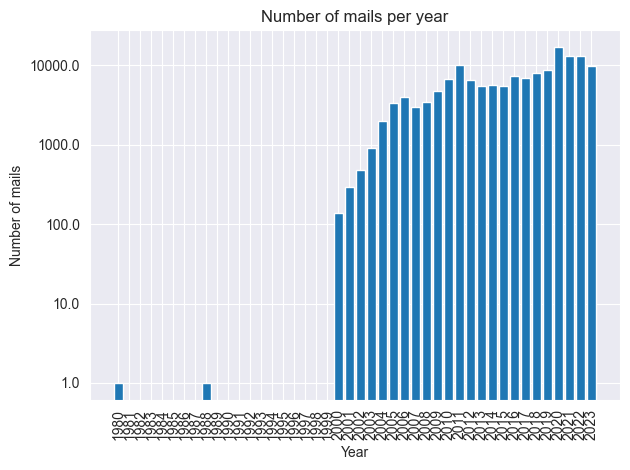

====== Timestamps ======
First: 2000-08-04 18:18:02+02:00
Last: 2023-11-16 13:04:20+00:00
{2000: 140, 2001: 298, 2002: 481, 2003: 901, 2004: 1972, 2005: 3409, 2006: 4044, 2007: 3004, 2008: 3428, 2009: 4832, 2010: 6714, 2011: 10166, 2012: 6560, 2013: 5569, 2014: 5624, 2015: 5514, 2016: 7352, 2017: 6936, 2018: 8096, 2019: 8710, 2020: 17012, 2021: 13121, 2022: 13190, 2023: 9736}


/var/folders/xv/v1t23m813h93mw4xw90v_x_00000gn/T/ipykernel_32724/2890229088.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(i) for i in ax.get_yticks()])


====== Connection Numbers ======


/var/folders/xv/v1t23m813h93mw4xw90v_x_00000gn/T/ipykernel_32724/322029201.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(i) for i in ax.get_yticks()])


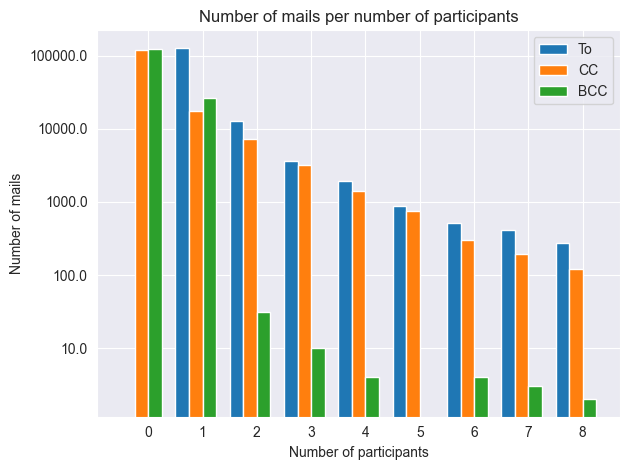

====== Shares (To) ======


====== Shares (From) ======


<Figure size 640x480 with 0 Axes>

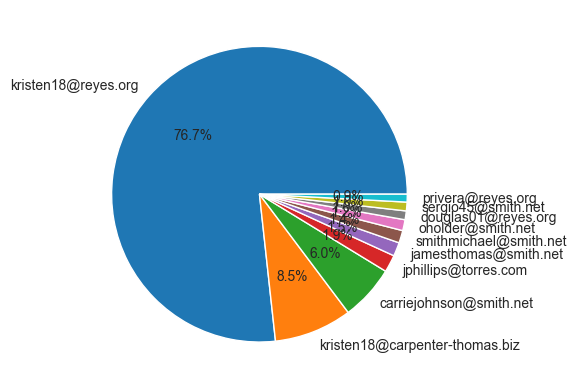

====== Heatmap ======


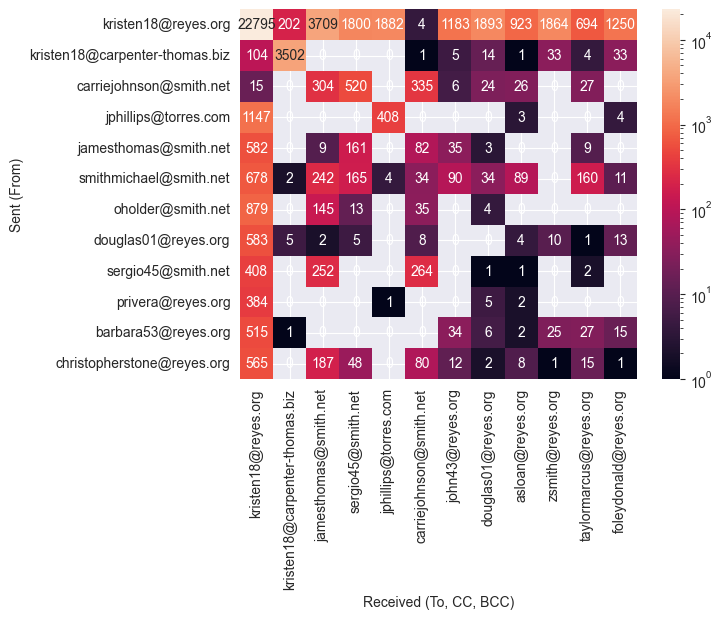

In [10]:
analyse_numbers(emlx_mails)
analyse_timestamps(emlx_mails, scale='log')
analyse_timestamps(emlx_mails, start_year=2000, end_year=2023, scale='linear')
analyse_connection_numbers(emlx_mails)
analyse_shares(emlx_mails)
analyse_heatmap(emlx_mails, 12)